Figures for Estuarine Exchange Paper

In [22]:
from salishsea_tools import nc_tools, viz_tools

from cmocean import cm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Rectangle
import netCDF4 as nc
from scipy.io import loadmat
import numpy as np
import xarray as xr

%matplotlib inline

## Map ##
copied heavily from http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/analysis-ben/raw/tip/notebooks/Maps.ipynb

In [2]:
plt.rcParams['font.size'] = 14

In [3]:
def plot_annotations(ax, m, annotations, zorder=None):
    """
    """
    
    # Plot Locations
    for annotation_label, annotation in annotations.items():
        ax.text(*annotation['text'], annotation_label, transform=ax.transAxes,
                fontsize=annotation['font']+1, rotation=annotation['rotate'], zorder=zorder)
        if annotation['marker'] is not None:
            x, y = m(*annotation['marker'])
            ax.plot(x, y, 'ko', markersize=8, markerfacecolor=annotation['color'], zorder=zorder)
        if annotation['arrow'] is not None:
            ax.arrow(*annotation['arrow'], head_width=0.01, fc='k', transform=ax.transAxes, zorder=zorder)

In [4]:
def plot_basemap(ax, w_map, lons=None, lats=None, offset=[None, None], zorder=[0, 1, 2]):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.floor([w_map[0], w_map[1] + 1])
    if lats is None:
        lats = np.floor([w_map[2], w_map[3] + 1])
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    m.fillcontinents(color='Burlywood', zorder=zorder[0])
    m.drawmeridians(np.arange(*lons), labels=[0, 0, 1, 0], color='dimgray', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(np.arange(*lats), labels=[0, 1, 0, 0], color='dimgray', xoffset=offset[0], zorder=zorder[2])
    
    return m

In [5]:
def plot_thalweg(ax, T_lon, T_lat):
    lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
    lines = lines.astype(int)

    thalweg_lon = T_lon[lines[:,0],lines[:,1]]
    thalweg_lat = T_lat[lines[:,0],lines[:,1]]
    ax.plot(thalweg_lon, thalweg_lat, 'r')
    
#    Victoria_sill_j = 178-1;
#    Victoria_sill_i = np.arange(235,302+1)-1
#    vs_lon = T_lon[Victoria_sill_i, Victoria_sill_j]
#    vs_lat = T_lat[Victoria_sill_i, Victoria_sill_j]
#    ax.plot(vs_lon, vs_lat, 'b')
#    ax.plot(thalweg_lon[1480], thalweg_lat[1480], 'r*')
#    ax.plot(thalweg_lon[1539], thalweg_lat[1539], 'ro')

In [57]:
def plot_map(ax, cst, bounds, grid, grid_old, T, w_map = [-127, -121, 46.5, 51.5]):
    """Plot Strait of Georgia study area on Basemap object
    """
    
    # Plot Basemap
    m = plot_basemap(ax, w_map, offset=[-30000, -15000], zorder=[0, 1, 7])
    
    # Plot Fraser River
    for bound in bounds:
        i_old = 0
        for i in np.argwhere(np.isnan(cst['ncst'][bound[0]:bound[1], 1]))[:, 0]:
            x, y = m(cst['ncst'][bound[0]:bound[1], 0][i_old:i],
                     cst['ncst'][bound[0]:bound[1], 1][i_old:i])
            ax.plot(x, y, 'k-')
            i_old = i + 1
    
    # Convert lon/lat to x, y
    x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)

    # Overlay model domain
    C = ax.contourf(x, y, T['vosaline'].isel(time_counter=23, deptht=0), range(21, 34), cmap='BrBG_r', extend='both', zorder=2)
    
    ax.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='dimgray', zorder=3)
    ax.contourf(x, y, grid_old['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
    ax.contour( x, y, grid_old['Bathymetry'], [0], colors='Black', zorder=4)

    # Colorbar
    fig.subplots_adjust(bottom=0.15)
    cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
    cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='Salinity [g/kg]')
    cbar.set_label(label='Salinity [g/kg]', size=14)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), size=14)
    #cbar.set_ticks(range(0, 550, 50))

    # Box around model domain
    ax.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
    ax.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
    ax.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
    ax.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)

    # Define Significant Landmarks and Locations
    annotations = {
        'Pacific\nOcean'     : {'text': [0.10, 0.250], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'British\nColumbia'  : {'text': [0.65, 0.850], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Washington\nState'  : {'text': [0.70, 0.030], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
       # 'Strait of Georgia'  : {'text': [0.50, 0.575], 'font': 13, 'rotate': -40, 'color': 'r', 'marker': None, 'arrow': None},
       # 'Juan de Fuca Strait': {'text': [0.36, 0.400], 'font': 13, 'rotate': -21, 'color': 'r', 'marker': None, 'arrow': None},
        'Fraser River'       : {'text': [0.80, 0.530], 'font': 13, 'rotate':  15, 'color': 'r', 'marker': None, 'arrow': None},
        'Puget\nSound'       : {'text': [0.60, 0.120], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
        'Vancouver'          : {'text': [0.68, 0.550], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.10, 49.25], 'arrow': None},
        'Victoria'           : {'text': [0.53, 0.380], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.37, 48.43], 'arrow': None},
        'Seattle'            : {'text': [0.81, 0.230], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-122.33, 47.61], 'arrow': None},
    }
    
    
    # Timestamp
    ax.text(0.02, 0.01, '15 April 2017 2330 UTC', transform=ax.transAxes)
    
    # Plot Annotations
    plot_annotations(ax, m, annotations, zorder=7)
    
    # Plot Thalweg
#    plot_thalweg(ax, x, y)

In [47]:
# Load NEMO grid
grid_NEMO = xr.open_dataset(
    '/home/sallen/MEOPAR/sea_initial/bathymetry_201803b.nc', mask_and_scale=False)
grid_OLD = xr.open_dataset(
    '/home/sallen/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)

T_NEMO = xr.open_dataset('/data/sallen/results/MEOPAR/new_waves/part2_06apr17/SalishSea_1h_20170406_20170505_grid_T_20170415-20170415.nc')

# Load Fraser coastline
PNWrivers = loadmat('/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat')

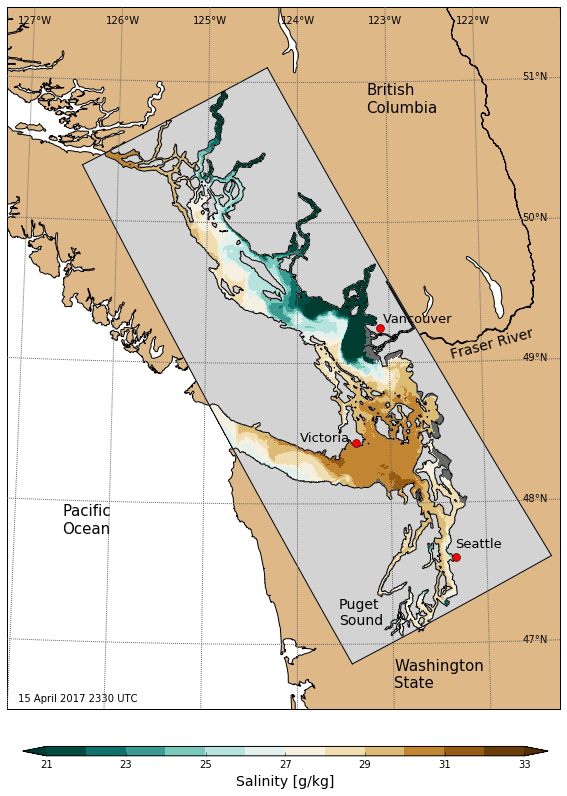

In [58]:
# Define Fraser coastline regions
bounds = [[0, 26000], [61500, 77000], [107500, 114000], [200000, 203000], [326000, 327000]]

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 13))

# Plot Model Domain
plot_map(ax, PNWrivers, bounds, grid_NEMO, grid_OLD, T_NEMO)

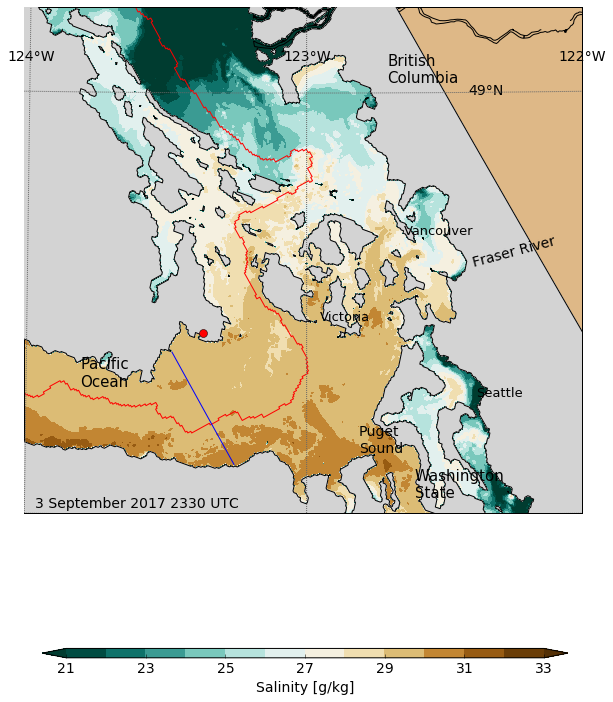

In [43]:
# Define Fraser coastline regions
bounds = [[0, 26000], [61500, 77000], [107500, 114000], [200000, 203000], [326000, 327000]]

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 13))

# Plot Model Domain
plot_map(ax, PNWrivers, bounds, grid_NEMO, T_NEMO, w_map = [-124, -122, 48, 49.2])



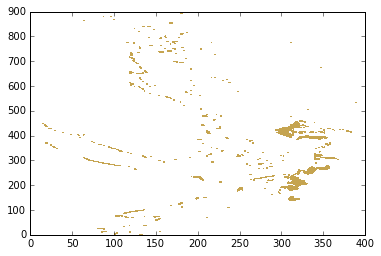

In [32]:
fig, ax = plt.subplots(1, 1)
x=1;y=1
plot_mudflats(ax, x, y)